In [1]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 22.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=c6197153f4bea2178d93bcfdb30d3484c7c469c94c63907e10e0fad570095dcb
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [2]:
import json
import torch
import torch_geometric.data as Data
import numpy as np
import scipy
import pandas as pd
from torch_geometric.data import HeteroData
from torch_geometric.nn import summary
import ast
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score

# Load json

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [4]:
path_yt = "/content/drive/MyDrive/BDE/Filtered_collections/youtube_collection.json"
path_twitter = "/content/drive/MyDrive/BDE/Filtered_collections/twitter_collection.json"
path_user = "/content/drive/MyDrive/BDE/Filtered_collections/user_collection.json"

with open(path_user, 'r') as user_file:
    user_json = json.load(user_file)

with open(path_twitter, 'r') as tweet_file:
    tweet_json = json.load(tweet_file)

with open(path_yt, 'r') as youtube_file:
    youtube_json = json.load(youtube_file)

# Load feature matrixes

In [5]:
x_yt = np.load("/content/drive/MyDrive/BDE/train_features/id_yt.npy")
y = np.load("/content/drive/MyDrive/BDE/train_features/label_yt.npy")
x_twitter = scipy.sparse.load_npz("/content/drive/MyDrive/BDE/train_features/sparse_twitter_matrix.npz")
x_user = scipy.sparse.load_npz("/content/drive/MyDrive/BDE/train_features/sparse_user_matrix.npz")

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

n_samples = x_yt.shape[0]
indices = np.arange(n_samples)
indices_train,indices_test, labels_train, labels_test = train_test_split(indices,y, test_size=0.2,stratify = y)

# Edge creation TWEET->USER

In [7]:
# Preprocess tweet_json to create a dictionary mapping userid to tweet indexes
tweet_indexes_by_userid = {}
for idx_tweet, tweet in enumerate(tweet_json):
    userid = tweet["userid"]
    if userid not in tweet_indexes_by_userid:
        tweet_indexes_by_userid[userid] = []
    tweet_indexes_by_userid[userid].append(idx_tweet)


# Loop through users and find matching tweet indexes
edges_twitter_user = []
for idx_user, user in enumerate(user_json):
    userid = user["userid"]
    if userid in tweet_indexes_by_userid:
        edges_twitter_user.extend([[idx_tweet, idx_user] for idx_tweet in tweet_indexes_by_userid[userid]])
 


In [8]:
edges_twitter_user_array = np.array(edges_twitter_user).T

# Edge creation yt -> tweet 

In [9]:
# Create a dictionary to map tweetid to its index in tweet_json
tweetid_to_index = {tweet["tweetid"]: idx for idx, tweet in enumerate(tweet_json)}

edges_yt_twitter = []
for idx_video, video in enumerate(youtube_json):
    tweet_ids = ast.literal_eval(video["tweet_ids"])
    # Use the dictionary to look up the index for each tweetid in constant time
    edges_yt_twitter.extend([[idx_video, tweetid_to_index[tweet_id]] for tweet_id in tweet_ids if tweet_id in tweetid_to_index])

In [10]:
edges_yt_twitter_train = []
edges_yt_twitter_test = []

for idx_video,_ in edges_yt_twitter:
  if idx_video in indices_train:
    edges_yt_twitter_train.append([idx_video,_])
  else:
    edges_yt_twitter_test.append([idx_video,_])


In [11]:
edges_yt_twitter_array = np.array(edges_yt_twitter).T

In [12]:
edges_yt_twitter_train_array = np.array(edges_yt_twitter_train).T
edges_yt_twitter_test_array = np.array(edges_yt_twitter_test).T

# Dataset creation

In [13]:
def calculate_num_features(data):
        num_features = 0
        # Calculate the total number of features from each data type
        num_features += data['yt'].x.shape[1]
        num_features += data['user'].x.shape[1]
        num_features += data['twitter'].x.shape[1]
        return num_features
    

def calculate_num_classes(data):
        # Calculate the number of classes based on the 'y' attribute
        num_classes = torch.unique(torch.tensor(data['yt'].y,dtype=torch.float32)).numel()
        return num_classes

In [14]:
def coo_to_tensor(x):
    indices = torch.tensor([x.row, x.col], dtype=torch.long)
    values = torch.tensor(x.data, dtype=torch.float)
    size = torch.Size(x.shape)
    tensor = torch.sparse_coo_tensor(indices, values, size)
    return tensor

def get_data(x_yt,edges_yt_twitter_array):
    data = HeteroData()

    #nodes
    data['yt'].x = torch.tensor(x_yt, dtype=torch.float) # [num_video, num_features_video] 
    data['user'].x =  coo_to_tensor(x_user) # [user, num_features_user] 
    data['twitter'].x = coo_to_tensor(x_twitter) # [twitter, num_features_tweet] 

    #edges
    data["twitter","user"].edge_index =  torch.tensor(edges_twitter_user_array, dtype=torch.long)
    data["yt","twitter"].edge_index = torch.tensor(edges_yt_twitter_array, dtype=torch.long)
    data["twitter","yt"].edge_index = torch.tensor(edges_yt_twitter_array, dtype=torch.long)[[1,0],:]

    #add relationship type
    data["twitter", "user"].edge_type = "twitter_to_user"
    data["yt", "twitter"].edge_type = "yt_to_twitter"
    data["twitter", "yt"].edge_type = "twitter_to_yt"
    
    #attr
    data["twitter"].num_nodes = x_twitter.shape[0]
    data["user"].num_nodes = x_user.shape[0]
    data["yt"].num_nodes = x_yt.shape[0]
    #data["yt"].y = torch.tensor(y, dtype=torch.float)
    data["twitter","yt"].edge_attr = None
    data["twitter","user"].edge_attr = None
    data["yt","twitter"].edge_attr = None
    return data

In [15]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import HGTConv, Linear
from torch import nn

class HGT(torch.nn.Module):
    def __init__(self, data,hidden_channels, num_heads, num_layers):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)
           

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data.metadata(),
                           num_heads, group='sum') #sum,min,mean
            self.convs.append(conv)

        self.dense = nn.Linear(1,17123)
        self.lin_label_prediction = nn.Linear(hidden_channels, 1)
        self.sigmoid = nn.Sigmoid()
        self.drop_out = nn.Dropout(p=0.5)

    def forward(self, x_dict, edge_index_dict):
        for node_type, x in x_dict.items():
            x_dict[node_type] = self.lin_dict[node_type](x).relu_()
            
       
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
        
        yt_x = x_dict['yt']
        yt_x = self.drop_out(yt_x)

        yt_logits = self.lin_label_prediction(yt_x)
        y_pred = self.sigmoid(yt_logits).squeeze()

        return y_pred

In [115]:
import gc

# Collect garbage to free up memory
gc.collect()

torch.cuda.empty_cache()
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data = get_data(x_yt,edges_yt_twitter_train_array).to(device)  # Move data to GPU

# Move the input data to the device
x_dict = {k: v.to(device) for k, v in train_data.x_dict.items()}
edge_index_dict = {k: v.to(device) for k, v in train_data.edge_index_dict.items()}


train_data.validate(raise_on_error=True)
hidden_channels=32
num_layers=3
num_heads=8

model = HGT(train_data, hidden_channels=hidden_channels, num_heads=num_heads, num_layers=num_layers).to(device)  # Move model to GPU

with torch.no_grad():  # Initialize lazy modules.
    out = model(x_dict, edge_index_dict)


# test graph

In [17]:
test_data = get_data(x_yt,edges_yt_twitter_test_array).to(device)  # Move data to GPU

# Move the input test data to the device
x_dict_test = {k: v.to(device) for k, v in test_data.x_dict.items()}
edge_index_dict_test = {k: v.to(device) for k, v in test_data.edge_index_dict.items()}

test_data.validate(raise_on_error=True)

True

In [18]:
labels_train_tensor = torch.tensor(labels_train,dtype = torch.float).squeeze().to(device)
labels_test_tensor = torch.tensor(labels_test,dtype = torch.float).squeeze().to(device)

In [19]:
indices_train_tensor = torch.tensor(indices_train,dtype=torch.long).to(device)
indices_test_tensor = torch.tensor(indices_test,dtype=torch.long).to(device)

In [117]:
# Define the optimizer and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.BCELoss()

# Define the number of training epochs
num_epochs = 400
list_recall = []
list_accuracy = []
list_loss = []
lista_macrof1 = []

list_recall_test = []
list_accuracy_test = []
list_loss_test = []
list_macrof1_test = []

 # Initialize variables for early stopping
best_macro_f1 = 0.0
patience = 1  # Number of epochs to wait for improvement
counter = 0  # Counter to keep track of epochs without improvement

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    # Forward pass
    output = model(train_data.x_dict, train_data.edge_index_dict)


    # Calculate the loss
    #loss = torch.nn.functional.cross_entropy(output[indices_train_tensor], labels_train_tensor)
    loss = loss_fn(output[indices_train_tensor], labels_train_tensor)
    accuracy = accuracy_score((output[indices_train_tensor]>=0.5).float().cpu().detach().numpy(), labels_train_tensor.cpu().detach().numpy())
    recall = recall_score((output[indices_train_tensor]>=0.5).float().cpu().detach().numpy(), labels_train_tensor.cpu().detach().numpy())
    macro_f1 = f1_score((output[indices_train_tensor]>=0.5).float().cpu().detach().numpy(), labels_train_tensor.cpu().detach().numpy(), average='macro')

    #save in the list
    list_loss.append(loss)
    list_recall.append(recall)
    list_accuracy.append(accuracy)
    list_accuracy.append(macro_f1)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    # Print progress
    print(f"Epoch: {epoch+1}/{num_epochs}, loss: {loss.item():.3f}, Accuracy: {accuracy:.3f}, Recall: {recall:.3f}, macro_f1: {macro_f1:.3f}")


    # Validation loop
    model.eval()

    with torch.no_grad():
        output_test =  model(test_data.x_dict, test_data.edge_index_dict)

        # Calculate the test oss
        #loss_test = torch.nn.functional.cross_entropy(output_test[indices_test_tensor], labels_test_tensor)
        loss_test = loss_fn(output_test[indices_test_tensor], labels_test_tensor)
        accuracy_test = accuracy_score((output_test[indices_test_tensor]>=0.5).float().cpu().detach().numpy(), labels_test_tensor.cpu().detach().numpy())
        recall_test = recall_score((output_test[indices_test_tensor]>=0.5).float().cpu().detach().numpy(), labels_test_tensor.cpu().detach().numpy())
        macro_f1_test = f1_score((output_test[indices_test_tensor]>=0.5).float().cpu().detach().numpy(), labels_test_tensor.cpu().detach().numpy(), average='macro')


        #save in the list
        list_loss_test.append(loss_test)
        list_recall_test.append(recall_test)
        list_accuracy_test.append(accuracy_test)
        list_macrof1_test.append(macro_f1_test)
      
        # Print progress
        print(f"Epoch: {epoch+1}/{num_epochs}, test_loss: {loss_test.item():.3f}, test_accuracy: {accuracy_test:.2f}, test_recall: {recall_test:.3f}, macro_f1_test: {macro_f1_test:.3f}")
      
         # Check if test accuracy dropped and recall increased
        if  macro_f1_test < best_macro_f1:
            counter += 1
            torch.save(model.state_dict(), f"/content/drive/MyDrive/BDE/Models/model_{best_macro_f1:.10f}.pt")  # Save the best model
        else:
            best_macro_f1 = macro_f1_test
            counter = 0

        # Check if early stopping condition is met
        if counter >= patience:
            print("Early stopping triggered!")
            break


   

Epoch: 1/400, loss: 0.148, Accuracy: 0.934, Recall: 0.770, macro_f1: 0.904
Epoch: 1/400, test_loss: 0.997, test_accuracy: 0.81, test_recall: 0.536, macro_f1_test: 0.679
Epoch: 2/400, loss: 0.127, Accuracy: 0.952, Recall: 0.876, macro_f1: 0.924
Epoch: 2/400, test_loss: 0.915, test_accuracy: 0.81, test_recall: 0.530, macro_f1_test: 0.678
Early stopping triggered!


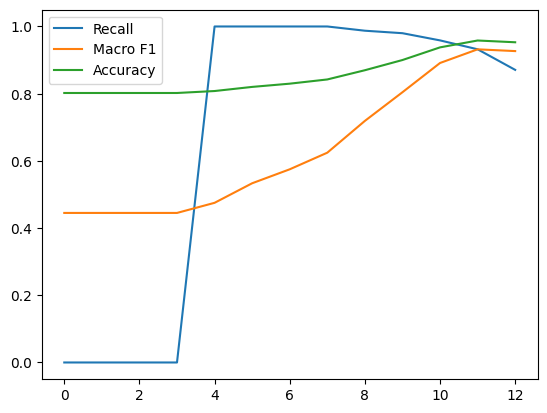

In [91]:
import matplotlib.pyplot as plt 
plt.plot(range(len(list_recall_test)),list_recall_test,label="Recall")
plt.plot(range(len(list_recall_test)),list_macrof1_test,label="Macro F1")
plt.plot(range(len(list_recall_test)),list_accuracy_test,label="Accuracy")
plt.savefig(f"/content/drive/MyDrive/BDE/Pics/model_{best_macro_f1:.10f}.jpg")
plt.legend()

# Loading model and computing metrics 

In [ ]:
path_model = '/content/drive/MyDrive/BDE/Models/model_0.6812752753.pt'
model_state = torch.load(path_model)
model.load_state_dict(model_state)

model.eval()
with torch.no_grad():
      output_test =  model(test_data.x_dict, test_data.edge_index_dict)

In [118]:
accuracy_test = accuracy_score((output_test[indices_test_tensor]>=0.5).float().cpu().detach().numpy(), labels_test_tensor.cpu().detach().numpy())
recall_test = recall_score((output_test[indices_test_tensor]>=0.5).float().cpu().detach().numpy(), labels_test_tensor.cpu().detach().numpy())
precision_score_test = precision_score((output_test[indices_test_tensor]>=0.5).float().cpu().detach().numpy(), labels_test_tensor.cpu().detach().numpy())
macro_f1_test = f1_score((output_test[indices_test_tensor]>=0.5).float().cpu().detach().numpy(), labels_test_tensor.cpu().detach().numpy(), average='macro')
confusion_metrix_test = confusion_matrix((output_test[indices_test_tensor]>=0.5).float().cpu().detach().numpy(), labels_test_tensor.cpu().detach().numpy())

In [119]:
print("accuracy: %.2f%%" % (accuracy_test * 100.0))
print("macro f1_Score: ",macro_f1_test)
print("recall: ",recall_test)
print("precision: ", precision_score_test)
print("confusion matrix: ",confusion_metrix_test)

accuracy: 81.17%
macro f1_Score:  0.678166641390556
recall:  0.5304990757855823
precision:  0.42330383480825956
confusion matrix:  [[2493  391]
 [ 254  287]]


In [ ]:
torch.save(model.state_dict(), f"/content/drive/MyDrive/BDE/Models/model_submission.pt")

In [ ]:
print(summary(model, train_data.x_dict, train_data.edge_index_dict))

+--------------------------------+------------------+----------------+------------+
| Layer                          | Input Shape      | Output Shape   | #Param     |
|--------------------------------+------------------+----------------+------------|
| HGT                            |                  | [17123]        | 11,987,988 |
| ├─(lin_dict)ModuleDict         | --               | --             | 11,911,040 |
| │    └─(yt)Linear              | [17123, 1]       | [17123, 32]    | 64         |
| │    └─(user)Linear            | [301724, 154816] | [301724, 32]   | 4,954,144  |
| │    └─(twitter)Linear         | [778617, 217400] | [778617, 32]   | 6,956,832  |
| ├─(convs)ModuleList            | --               | --             | 42,669     |
| │    └─(0)HGTConv              |                  |                | 14,223     |
| │    └─(1)HGTConv              |                  |                | 14,223     |
| │    └─(2)HGTConv              |                  |                | 14,22

# Computing predictions


In [80]:
path_test = "/content/drive/MyDrive/BDE/Filtered_collections/y_test_collection.json"
csv_test_path  = "/content/drive/MyDrive/BDE/Predictions/y_test.csv"

with open(path_test, 'r') as test_file:
    test_json = json.load(test_file)

df_test = pd.read_csv(csv_test_path)

YT -> TWITTER

In [81]:
# Create a dictionary to map tweetid to its index in tweet_json
tweetid_to_index = {tweet["tweetid"]: idx for idx, tweet in enumerate(tweet_json)}

edges_yt_twitter_test = []
for idx_video, video in enumerate(test_json):
    tweet_ids = video["tweet_ids"]
    # Use the dictionary to look up the index for each tweetid in constant time
    edges_yt_twitter_test.extend([[idx_video, tweetid_to_index[tweet_id]] for tweet_id in tweet_ids if tweet_id in tweetid_to_index])

In [82]:
edges_yt_twitter_test_array = np.array(edges_yt_twitter_test).T

In [83]:
n = len(test_json)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_test_yt = np.ones((n,1))

test_graph = get_data(x_test_yt,edges_yt_twitter_test_array).to(device)  # Move data to GPU
test_graph.validate(raise_on_error=True)

True

In [84]:
path_model = f"/content/drive/MyDrive/BDE/Models/model_{best_macro_f1:.10f}.pt"
#path_model = '/content/drive/MyDrive/BDE/Models/model_0.6826339487.pt'
model_state = torch.load(path_model)
model = HGT(test_graph, hidden_channels=hidden_channels, num_heads=num_heads, num_layers=num_layers).to(device)  # Move model to GPU
model.load_state_dict(model_state)

<All keys matched successfully>

In [85]:
#Put the model in evaluation mode
model.eval()

# Pass the input through the model
with torch.no_grad():
    output = model(test_graph.x_dict, test_graph.edge_index_dict)

In [86]:
output.shape

torch.Size([1903])

In [87]:
y_test = (output>=0.5).float()

In [88]:
print(f"Percentuale mod: {((y_test==1).sum())/y_test.shape[0]}")

Percentuale mod: 0.1954808235168457


In [89]:
df_test["moderationStatus"] =  np.where((y_test == 0).detach().cpu().numpy(), "not moderated", "moderated") 

In [90]:
df_test.to_csv(f"/content/drive/MyDrive/BDE/Predictions/model_{best_macro_f1:.10f}_y.csv",index=False)

In [ ]:
save_path = f"/content/drive/MyDrive/BDE/Predictions/model_{best_macro_f1:.10f}_y.pt"
torch.save(y_test, save_path)